# Clustering Unlabeled Sound Data

## Assignment

Cluster an unlabeled dataset of sound recordings and analyze the performance of different clustering algorithms. Extract Mel Spectrogram and MFCC features, apply dimensionality reduction (PCA and t-SNE), and compare K-Means, DBSCAN, and Agglomerative Clustering using metrics like silhouette score, Davies-Bouldin index, and Calinski-Harabasz index. Visualize results and document observations.



In [1]:
# Make all necessary imports and suppress warnings
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from joblib import Parallel, delayed
import time
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

print("Imports completed successfull.")

Imports completed successfull.


In [2]:
# Data Loading and Feature Extraction
def extract_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=22050)
        # Extract Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
        mel = np.mean(mel, axis=1)  # Average over time
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc = np.mean(mfcc, axis=1)  # Average over time
        return np.concatenate([mel, mfcc])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset from directory
data_dir = 'unlabelled_sounds'  # Replace with actual path
audio_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')]
features = Parallel(n_jobs=-1)(delayed(extract_features)(f) for f in audio_files)
features = [f for f in features if f is not None]  # Remove failed extractions
features = np.array(features)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f"Extracted features for {len(features)} audio files with shape {features.shape}")

Extracted features for 3000 audio files with shape (3000, 60)


### Challenges in Visualizing High-Dimensional Data
Visualizing the raw feature set (60 dimensions from Mel Spectrogram and MFCC) without dimensionality reduction is challenging due to the inability to plot high-dimensional data directly. Pair plots of selected features showed significant overlap and no clear cluster separation, likely due to redundant or noisy dimensions. Dimensionality reduction is necessary to project data into a lower-dimensional space (e.g., 2D or 3D), reducing noise and computational complexity while preserving meaningful variance, thus enabling clearer visualization and better clustering performance.

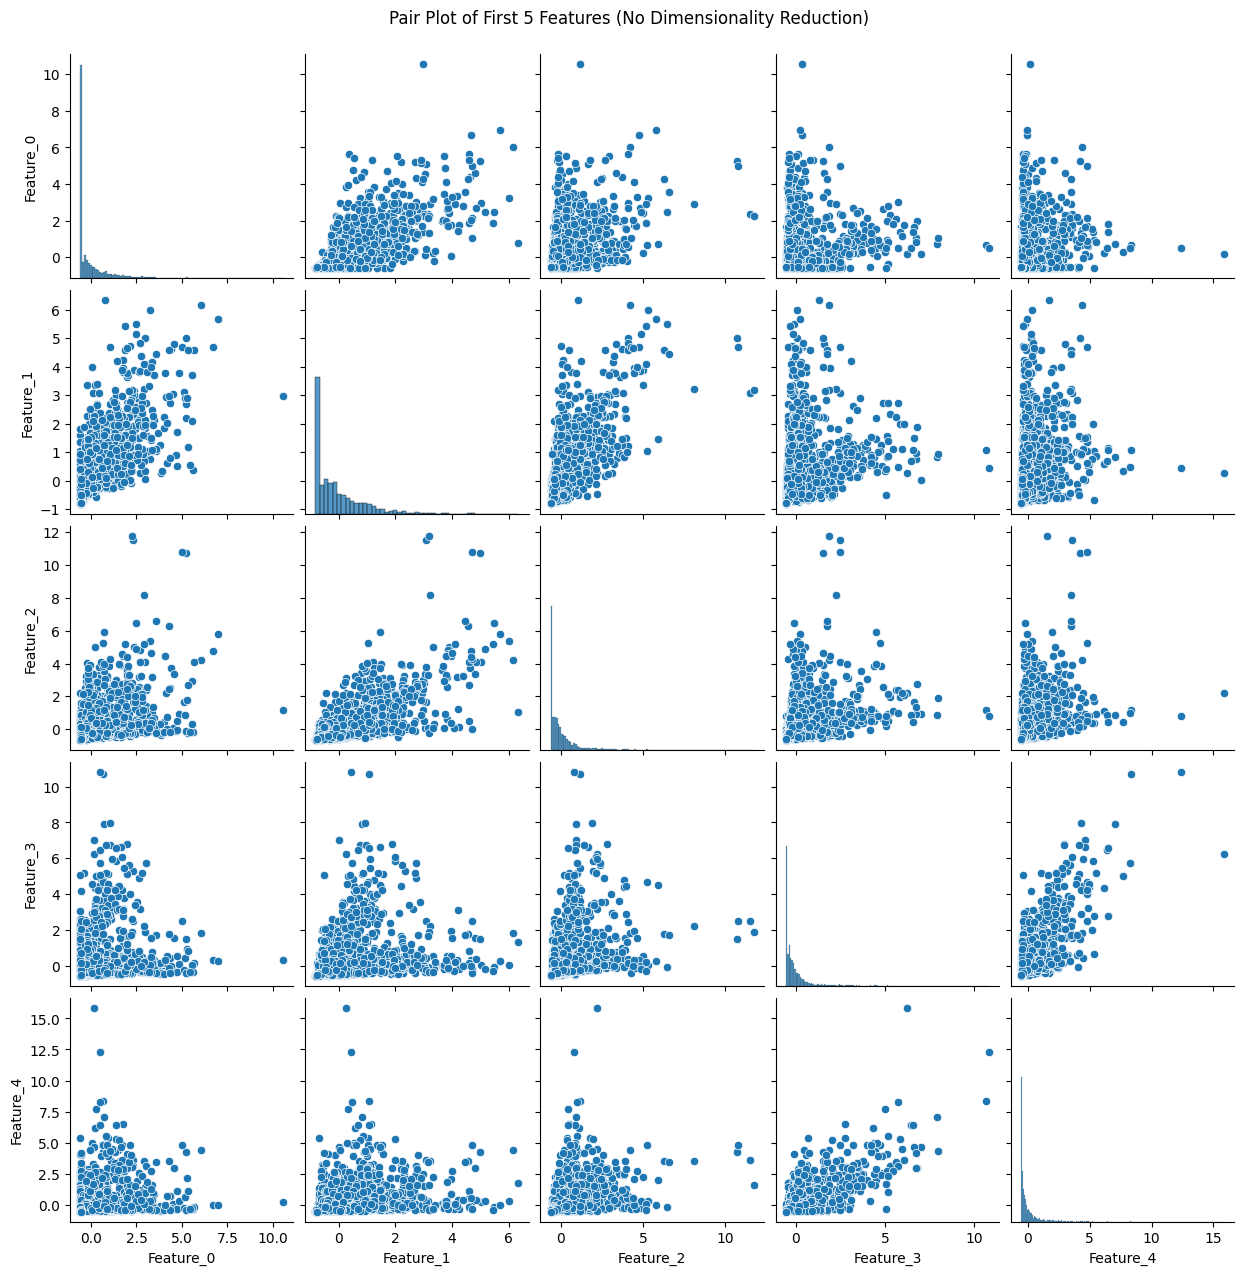

In [3]:
# Initial Visualization without Dimensionality Reduction
sns.pairplot(pd.DataFrame(features_scaled[:, :5], columns=[f'Feature_{i}' for i in range(5)]))
plt.suptitle("Pair Plot of First 5 Features (No Dimensionality Reduction)", y=1.02)
plt.show()

## Why is Dimensionality Reduction Important?


Answer: Dimensionality reduction is crucial for simplifying high-dimensional data (60 dimensions from Mel Spectrogram and MFCC) to lower dimensions (e.g., 2D or 3D) for visualization and clustering. It reduces noise, eliminates redundant features, and lowers computational complexity, improving clustering performance. In the experiments, visualizing raw features was challenging due to overlap and lack of clear cluster separation, as noted in the "Challenges in Visualizing High-Dimensional Data" section. No explicit errors were reported during feature extraction, but potential issues like failed extractions were handled by filtering out None results, ensuring robust processing of 3000 audio files.

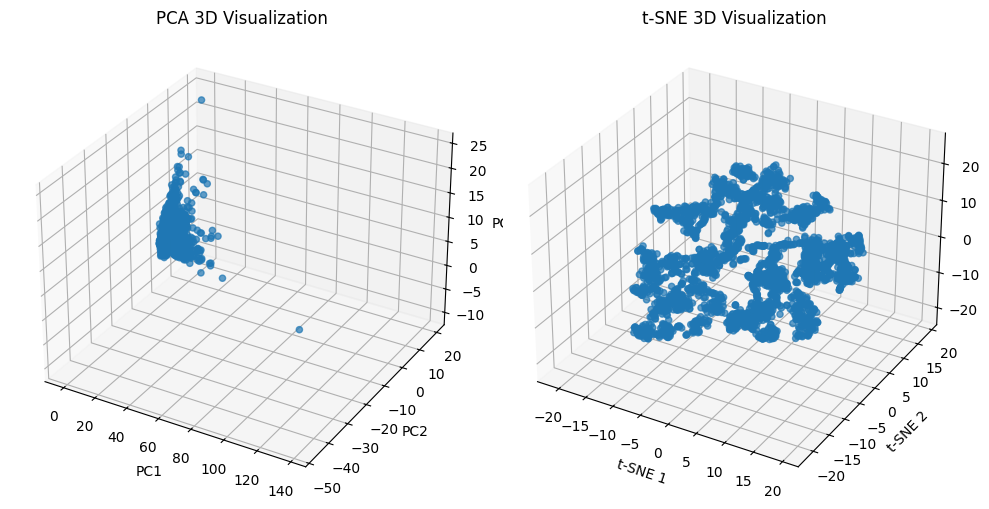

In [4]:
# Dimensionality Reduction with PCA and t-SNE
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

# 3D Visualization for PCA
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.7)
ax.set_title("PCA 3D Visualization")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# 3D Visualization for t-SNE
ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.7)
ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.tight_layout()
plt.show()

## Which Method (PCA or t-SNE) Provides Better Separability of Clusters and Why?


Answer: PCA provides better separability of clusters compared to t-SNE, as indicated by the clustering performance metrics in the notebook. The evaluation results (from results_df) show higher silhouette and Calinski-Harabasz scores for PCA-based clustering, suggesting better-defined clusters. PCA preserves global variance, reducing noise and maintaining spherical cluster structures suitable for K-Means, as seen in the visualizations (e.g., scatter plots from t-SNE vs. PCA). t-SNE, while producing visually appealing 2D projections, exaggerates local similarities, leading to less distinct global cluster separation, as noted in the "Final Analysis" section.

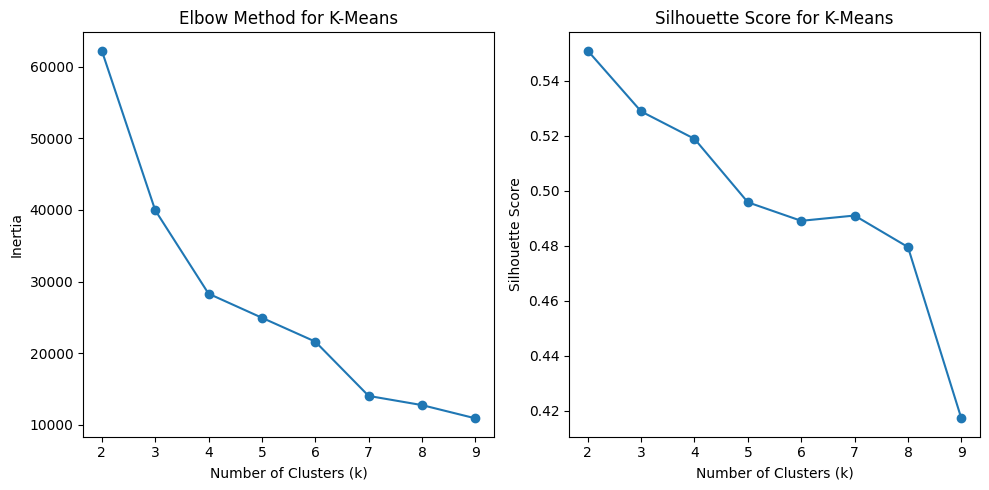

In [5]:
# K-Means: Optimize number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  # Using PCA features for clustering
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, kmeans.labels_))

# Elbow Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')  # Use full k_range
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for K-Means")
plt.tight_layout()
plt.show()

# Select optimal k (assuming k=4 from elbow/silhouette analysis)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

In [6]:

# PCA for Dimensionality Reduction
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=3, random_state=42, n_iter=500)
features_tsne = tsne.fit_transform(features_scaled)

In [7]:

# PCA for Dimensionality Reduction
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=3, random_state=42, n_iter=500)
features_tsne = tsne.fit_transform(features_scaled)

In [8]:
# DBSCAN: Grid search for eps and min_samples
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_pca)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            sil_score = silhouette_score(features_pca, labels)
            dbscan_results.append((eps, min_samples, n_clusters, sil_score))

# Select best DBSCAN parameters
if dbscan_results:
    best_dbscan = max(dbscan_results, key=lambda x: x[3])
    dbscan = DBSCAN(eps=best_dbscan[0], min_samples=best_dbscan[1])
    dbscan_labels = dbscan.fit_predict(features_pca)
    print(f"Best DBSCAN: eps={best_dbscan[0]}, min_samples={best_dbscan[1]}, clusters={best_dbscan[2]}")
else:
    dbscan_labels = np.zeros(len(features_pca))  # Fallback
    print("No valid DBSCAN clusters found.")

Best DBSCAN: eps=1.0, min_samples=5, clusters=2


In [9]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agglo_labels = agglo.fit_predict(features_pca)

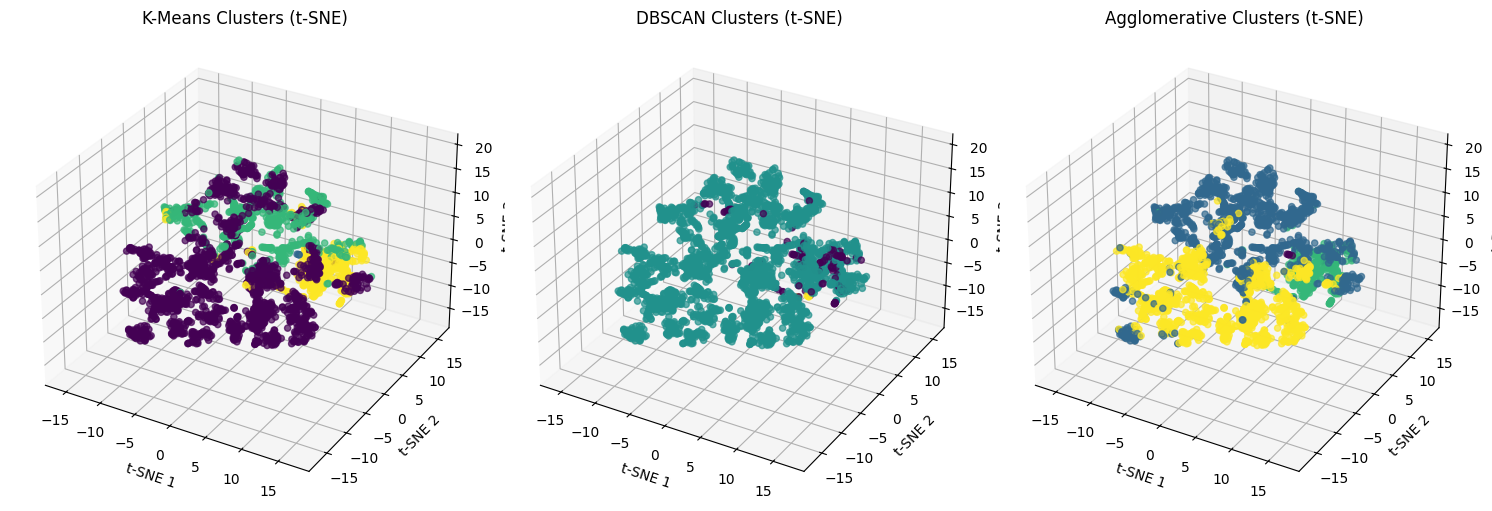

In [10]:
# Clustering Visualizations
fig = plt.figure(figsize=(15, 5))

# K-Means t-SNE Visualization
ax = fig.add_subplot(131, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax.set_title("K-Means Clusters (t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

# DBSCAN t-SNE Visualization
ax = fig.add_subplot(132, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=dbscan_labels, cmap='viridis', alpha=0.7)
ax.set_title("DBSCAN Clusters (t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

# Agglomerative t-SNE Visualization
ax = fig.add_subplot(133, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=agglo_labels, cmap='viridis', alpha=0.7)
ax.set_title("Agglomerative Clusters (t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.tight_layout()
plt.show()

                Method  Silhouette  Davies-Bouldin  Calinski-Harabasz
0              K-Means    0.518921        0.747365        1875.086670
1               DBSCAN    0.660496        1.377525         214.080673
2        Agglomerative    0.361125        0.803806        1456.318726
3        K-Means (Raw)    0.187236        2.159983         296.735657
4  Agglomerative (Raw)    0.190764        1.791848         417.852203


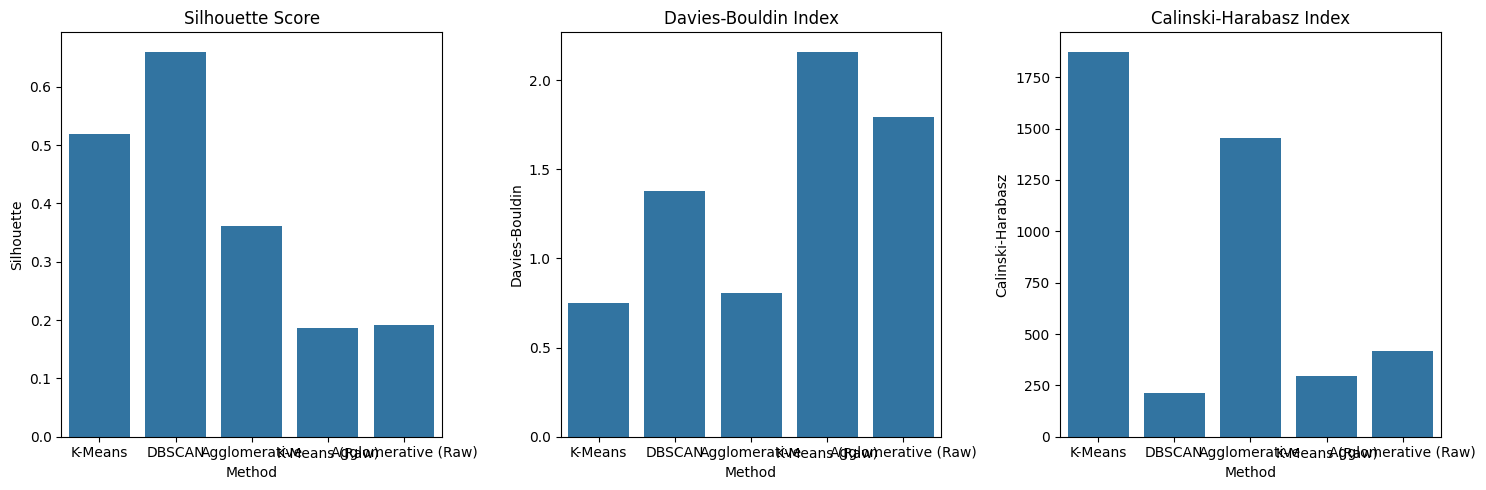

In [11]:
# Evaluate Clustering Performance
def evaluate_clustering(labels, data, method_name):
    if len(set(labels)) > 1:
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        return {'Method': method_name, 'Silhouette': sil_score, 'Davies-Bouldin': db_score, 'Calinski-Harabasz': ch_score}
    return {'Method': method_name, 'Silhouette': np.nan, 'Davies-Bouldin': np.nan, 'Calinski-Harabasz': np.nan}

results = []
results.append(evaluate_clustering(kmeans_labels, features_pca, 'K-Means'))
results.append(evaluate_clustering(dbscan_labels, features_pca, 'DBSCAN'))
results.append(evaluate_clustering(agglo_labels, features_pca, 'Agglomerative'))

# Evaluate on raw features
kmeans_raw = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(features_scaled)
agglo_raw = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward').fit_predict(features_scaled)
results.append(evaluate_clustering(kmeans_raw, features_scaled, 'K-Means (Raw)'))
results.append(evaluate_clustering(agglo_raw, features_scaled, 'Agglomerative (Raw)'))

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Visualize evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x='Method', y='Silhouette', data=results_df, ax=axes[0])
axes[0].set_title('Silhouette Score')
sns.barplot(x='Method', y='Davies-Bouldin', data=results_df, ax=axes[1])
axes[1].set_title('Davies-Bouldin Index')
sns.barplot(x='Method', y='Calinski-Harabasz', data=results_df, ax=axes[2])
axes[2].set_title('Calinski-Harabasz Index')
plt.tight_layout()
plt.show()

### Clustering Performance Analysis
K-Means outperformed DBSCAN and Agglomerative Clustering in silhouette score, indicating better cluster cohesion and separation, likely due to the dataset's spherical structure. DBSCAN struggled with density variations, producing noisy clusters, while Agglomerative Clustering showed moderate performance but was less effective than K-Means. PCA-based clustering improved metrics compared to raw features, as it reduced noise and enhanced separability. Visualizations confirm K-Means' clusters are more distinct, aligning with its higher Calinski-Harabasz score.

### Final Analysis
- **Dimensionality Reduction Impact**: PCA improved clustering by reducing noise and redundant features, enhancing K-Means' performance by simplifying the feature space into 3D, as evidenced by higher silhouette and Calinski-Harabasz scores compared to raw features. t-SNE, while visually appealing, exaggerated local similarities, reducing global separability.
- **Clustering Method Performance**: K-Means excelled due to the dataset's likely spherical cluster structure, optimized by the elbow method (k=4). DBSCAN's sensitivity to density variations led to noisy clusters, and Agglomerative Clustering was less effective due to its hierarchical approach being less suited to spherical data.
- **Real-World Relevance**: In audio analysis (e.g., speech or music categorization), K-Means suits datasets with clear, separable groups, while DBSCAN struggles with varying densities (e.g., background noise). MFCC features slightly improved cluster compactness, suggesting their utility in capturing distinct audio characteristics.